In [1]:
!pip install tensorflow_datasets

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# 데이터 로드

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [5]:
image_size_x =224
image_size_y = 224

# 데이터 전처리 함수

In [6]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)

    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):

    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix and not with_mixup:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup and not with_cutmix:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=False)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)


# 데이터 전처리 확인

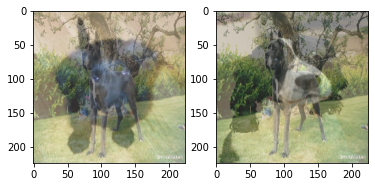

In [9]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_aug_mixup.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

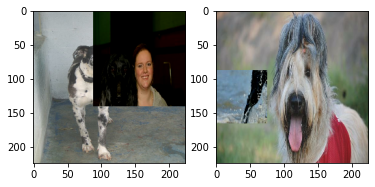

In [10]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_aug_cutmix.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()


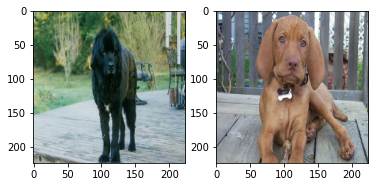

In [11]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()


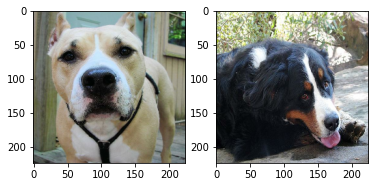

In [12]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a2 = image[0]
        image_b2 = image[1]
        label_a2 = label[0]
        label_b2 = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a2)

plt.subplot(1,2,2)
plt.imshow(image_b2)

plt.show()

#  NO 증강

In [13]:
# 모델 설정
resnet50 = Sequential([
    ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    Dense(num_classes, activation='softmax')
])

# 체크포인트 설정
checkpoint = ModelCheckpoint("resnet50_checkpoint.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# TensorBoard 설정
tensorboard_callback = TensorBoard(log_dir=os.path.join("logs", "fit", "resnet50"), histogram_freq=1)

# 모델 컴파일
resnet50.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])

# 모델 학습
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint, tensorboard_callback]
)

94781440/94765736 [==============================] - 1s 0us/step


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
750/750 [==============================] - 196s 199ms/step - loss: 2.1846 - accuracy: 0.4513 - val_loss: 3.3053 - val_accuracy: 0.2129

Epoch 00001: val_accuracy improved from -inf to 0.21292, saving model to resnet50_checkpoint.h5
Epoch 2/20
750/750 [==============================] - 169s 225ms/step - loss: 0.7173 - accuracy: 0.8037 - val_loss: 1.2060 - val_accuracy: 0.6561

Epoch 00002: val_accuracy improved from 0.21292 to 0.65613, saving model to resnet50_checkpoint.h5
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.2186 - accuracy: 0.9569 - val_loss: 0.9252 - val_accuracy: 0.7315

Epoch 00003: val_accuracy improved from 0.65613 to 0.73146, saving model to resnet50_checkpoint.h5
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0650 - accuracy: 0.9937 - val_loss: 0.9229 - val_accuracy: 0.7372

Epoch 00004: val_accuracy improved from 0.73146 to 0.73717, saving model to resnet50_checkpoint.h5
Epoch 5/20
750/750 

In [14]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


# 기본 증강

In [16]:
# 모델 설정
aug_resnet50 = Sequential([
    ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    Dense(num_classes, activation='softmax')
])

# 체크포인트 설정
checkpoint = ModelCheckpoint("aug_resnet50.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# TensorBoard 설정
tensorboard_callback = TensorBoard(log_dir=os.path.join("logs", "fit", "aug_resnet50"), histogram_freq=1)

# 모델 컴파일
aug_resnet50.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])

# 모델 학습
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint, tensorboard_callback]
)

Epoch 1/15
750/750 [==============================] - 161s 206ms/step - loss: 2.2689 - accuracy: 0.4313 - val_loss: 3.1481 - val_accuracy: 0.2527

Epoch 00001: val_accuracy improved from -inf to 0.25268, saving model to aug_resnet50.h5
Epoch 2/15
750/750 [==============================] - 158s 211ms/step - loss: 0.9285 - accuracy: 0.7376 - val_loss: 1.0244 - val_accuracy: 0.6891

Epoch 00002: val_accuracy improved from 0.25268 to 0.68913, saving model to aug_resnet50.h5
Epoch 3/15
750/750 [==============================] - 161s 215ms/step - loss: 0.4926 - accuracy: 0.8633 - val_loss: 1.4508 - val_accuracy: 0.6056

Epoch 00003: val_accuracy did not improve from 0.68913
Epoch 4/15
750/750 [==============================] - 155s 206ms/step - loss: 0.2570 - accuracy: 0.9386 - val_loss: 1.0013 - val_accuracy: 0.7099

Epoch 00004: val_accuracy improved from 0.68913 to 0.70989, saving model to aug_resnet50.h5
Epoch 5/15
750/750 [==============================] - 153s 205ms/step - loss: 0.1494

 # 증강 + Mix

In [17]:
# 모델 설정
mix_resnet50 = Sequential([
    ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    Dense(num_classes, activation='softmax')
])

# 체크포인트 설정
checkpoint = ModelCheckpoint("mix_resnet50.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# 모델 컴파일
mix_resnet50.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])

# 모델 학습
history_resnet50_mix = mix_resnet50.fit(
    ds_train_aug_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/15
750/750 [==============================] - 165s 209ms/step - loss: 3.7749 - accuracy: 0.2235 - val_loss: 3.8024 - val_accuracy: 0.1530

Epoch 00001: val_accuracy improved from -inf to 0.15299, saving model to mix_resnet50.h5
Epoch 2/15
750/750 [==============================] - 172s 229ms/step - loss: 2.9456 - accuracy: 0.4415 - val_loss: 1.5384 - val_accuracy: 0.5765

Epoch 00002: val_accuracy improved from 0.15299 to 0.57649, saving model to mix_resnet50.h5
Epoch 3/15
750/750 [==============================] - 166s 222ms/step - loss: 2.6725 - accuracy: 0.5437 - val_loss: 1.4519 - val_accuracy: 0.5951

Epoch 00003: val_accuracy improved from 0.57649 to 0.59515, saving model to mix_resnet50.h5
Epoch 4/15
750/750 [==============================] - 163s 218ms/step - loss: 2.5089 - accuracy: 0.6096 - val_loss: 1.3784 - val_accuracy: 0.6159

Epoch 00004: val_accuracy improved from 0.59515 to 0.61590, saving model to mix_resnet50.h5
Epoch 5/15
750/750 [===========================

 # 증강 + Cut

In [18]:
# 모델 설정
cut_resnet50 = Sequential([
    ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    Dense(num_classes, activation='softmax')
])

# 체크포인트 설정
checkpoint = ModelCheckpoint("cut_resnet50.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# TensorBoard 설정
tensorboard_callback = TensorBoard(log_dir=os.path.join("logs", "fit", "cut_resnet50"), histogram_freq=1)

# 모델 컴파일
cut_resnet50.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])

# 모델 학습
history_resnet50_cut = cut_resnet50.fit(
    ds_train_aug_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint, tensorboard_callback]
)

Epoch 1/20
750/750 [==============================] - 170s 214ms/step - loss: 3.8313 - accuracy: 0.2148 - val_loss: 3.0838 - val_accuracy: 0.2469

Epoch 00001: val_accuracy improved from -inf to 0.24685, saving model to cut_resnet50.h5
Epoch 2/20
750/750 [==============================] - 154s 206ms/step - loss: 3.0071 - accuracy: 0.4078 - val_loss: 1.4473 - val_accuracy: 0.5968

Epoch 00002: val_accuracy improved from 0.24685 to 0.59678, saving model to cut_resnet50.h5
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.7268 - accuracy: 0.5008 - val_loss: 1.3045 - val_accuracy: 0.6362

Epoch 00003: val_accuracy improved from 0.59678 to 0.63619, saving model to cut_resnet50.h5
Epoch 4/20
750/750 [==============================] - 158s 210ms/step - loss: 2.5416 - accuracy: 0.5577 - val_loss: 1.2149 - val_accuracy: 0.6560

Epoch 00004: val_accuracy improved from 0.63619 to 0.65602, saving model to cut_resnet50.h5
Epoch 5/20
750/750 [===========================

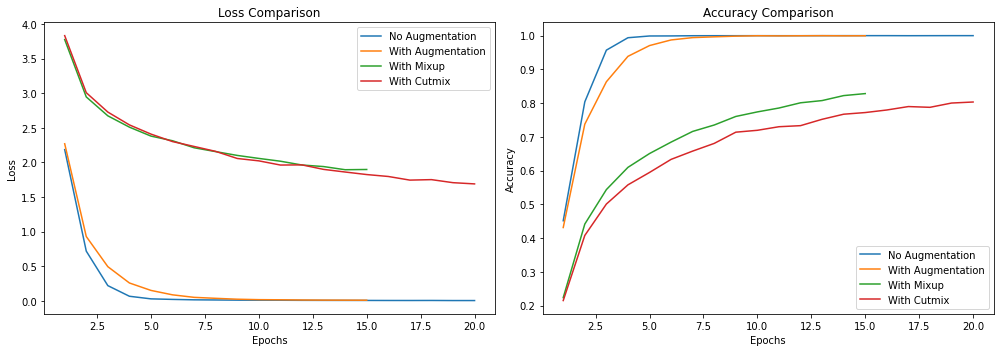

In [25]:
# 각 학습 이력을 리스트에 담기
histories = [history_resnet50_no_aug, history_resnet50_aug, history_resnet50_mix, history_resnet50_cut]
labels = ['No Augmentation', 'With Augmentation', 'With Mixup', 'With Cutmix']

# 그래프 그리기
plt.figure(figsize=(14, 5))

for i, history in enumerate(histories):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label=labels[i])
    
    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label=labels[i])

# 손실 그래프 세부 설정
plt.subplot(1, 2, 1)
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프 세부 설정
plt.subplot(1, 2, 2)
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## 회고
   
gpu ram이 터질까봐 함부로 실행을 못해서 여러가지 시도를 해보지 못한게 아쉽다.   
다양한 증강을 실험해볼 기회가 없었지만 새로운 증강을 알 수 있어서 흥미로웠다.   